# 1. Introduction

While exploring regression, we've briefly mentioned overfitting and the problems it can cause. In this mission, we'll explore how to identify overfitting and what you can do to avoid it. To explore overfitting, we'll use a dataset on cars which contains 7 numerical features that could have an effect on a car's fuel efficiency:

* cylinders -- the number of cylinders in the engine.
* displacement -- the displacement of the engine.
* horsepower -- the horsepower of the engine.
* weight -- the weight of the car.
* acceleration -- the acceleration of the car.
* model year -- the year that car model was released (e.g. 70 corresponds to 1970).
* origin -- where the car was manufactured (0 if North America, 1 if Europe, 2 if Asia).

The mpg column is our target column and is the one we want to predict using the other features.

The dataset is hosted by the University of California Irvine on [their machine learning repository](https://archive.ics.uci.edu/ml/datasets/Auto+MPG). You'll notice that the Data Folder contains a few different files. We'll be working with [auto-mpg.data](https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data), which omits the 8 rows containing missing values for fuel efficiency (mpg column).

In [1]:
import pandas as pd

columns = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model year", "origin", "car name"]

cars = pd.read_table("auto-mpg.data", delim_whitespace=True, names=columns)
filtered_cars = cars[cars['horsepower'] != '?'].copy()
filtered_cars['horsepower'] = filtered_cars['horsepower'].astype('float')
filtered_cars.head()

C:\Users\krishna\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


# 2. Bias and Variance

At the heart of understanding overfitting is understanding bias and variance. `Bias and variance make up the 2 observable sources of error in a model that we can indirectly control.`

Bias describes error that results in bad assumptions about the learning algorithm. For example, assuming that only one feature, like a car's weight, relates to a car's fuel efficiency will lead you to fit a simple, univariate regression model that will result in high bias. The error rate will be high since a car's fuel efficiency is affected by many other factors besides just its weight.

Variance describes error that occurs because of the variability of a model's predicted values. If we were given a dataset with 1000 features on each car and used every single feature to train an incredibly complicated multivariate regression model, we will have low bias but high variance.

`In an ideal world, we want low bias and low variance but in reality, there's always a tradeoff.`

# 3. Bias-variance tradeoff

We've discussed before how overfitting generally happens when a model performs well on a training set but doesn't generalize well to new data. A key nuance here is that you should think of overfitting as a relative term. Between any 2 models, one will overfit more than the other one.

Scott Fortman Roe's [blog post on the bias-variance tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html) has a wonderful image that describes this tradeoff:

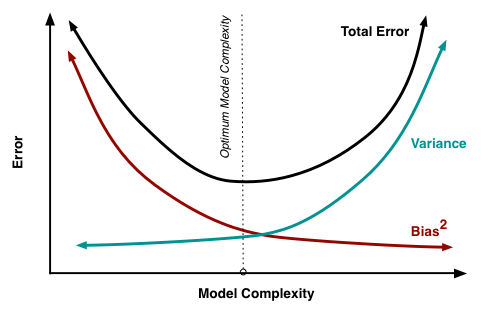

In [2]:
from IPython.display import Image
Image(filename='2xqTu46.png')

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
def train_and_test(cols):
    # Split into features & target.
    features = filtered_cars[cols]
    target = filtered_cars["mpg"]
    # Fit model.
    lr = LinearRegression()
    lr.fit(features, target)
    # Make predictions on training set.
    predictions = lr.predict(features)
    # Compute MSE and Variance.
    mse = mean_squared_error(filtered_cars["mpg"], predictions)
    variance = np.var(predictions)
    return(mse, variance)
    
cyl_mse, cyl_var = train_and_test(["cylinders"])
weight_mse, weight_var = train_and_test(["weight"])

# 4. Multivariate models

In [4]:
# Our implementation for train_and_test, takes in a list of strings.
def train_and_test(cols):
    # Split into features & target.
    features = filtered_cars[cols]
    target = filtered_cars["mpg"]
    # Fit model.
    lr = LinearRegression()
    lr.fit(features, target)
    # Make predictions on training set.
    predictions = lr.predict(features)
    # Compute MSE and Variance.
    mse = mean_squared_error(filtered_cars["mpg"], predictions)
    variance = np.var(predictions)
    return(mse, variance)

one_mse, one_var = train_and_test(["cylinders"])
two_mse, two_var = train_and_test(["cylinders", "displacement"])
three_mse, three_var = train_and_test(["cylinders", "displacement", "horsepower"])
four_mse, four_var = train_and_test(["cylinders", "displacement", "horsepower", "weight"])
five_mse, five_var = train_and_test(["cylinders", "displacement", "horsepower", "weight", "acceleration"])
six_mse, six_var = train_and_test(["cylinders", "displacement", "horsepower", "weight", "acceleration", "model year"])
seven_mse, seven_var = train_and_test(["cylinders", "displacement", "horsepower", "weight", "acceleration","model year", "origin"])

# 5. Cross validation

The multivariate regression models you trained got progressively better at reducing the amount of error.

A good way to detect if your model is overfitting is to compare the in-sample error and the out-of-sample error, or the training error with the test error. So far, we calculated the in sample error by testing the model over the same data it was trained on. To calculate the out-of-sample error, we need to test the data on a test set of data. We unfortunately don't have a separate test dataset and we'll instead use cross validation.

If a model's cross validation error (out-of-sample error) is much higher than the in sample error, then your data science senses should start to tingle. This is the first line of defense against overfitting and is a clear indicator that the trained model doesn't generalize well outside of the training set.

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
def train_and_cross_val(cols):
    features = filtered_cars[cols]
    target = filtered_cars["mpg"]
    
    variance_values = []
    mse_values = []
    
    # KFold instance.
    kf = KFold(n_splits=10, shuffle=True, random_state=3)
    
    # Iterate through over each fold.
    for train_index, test_index in kf.split(features):
        # Training and test sets.
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # Fit the model and make predictions.
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        predictions = lr.predict(X_test)
        
        # Calculate mse and variance values for this fold.
        mse = mean_squared_error(y_test, predictions)
        var = np.var(predictions)

        # Append to arrays to do calculate overall average mse and variance values.
        variance_values.append(var)
        mse_values.append(mse)
   
    # Compute average mse and variance values.
    avg_mse = np.mean(mse_values)
    avg_var = np.mean(variance_values)
    return(avg_mse, avg_var)
        
two_mse, two_var = train_and_cross_val(["cylinders", "displacement"])
three_mse, three_var = train_and_cross_val(["cylinders", "displacement", "horsepower"])
four_mse, four_var = train_and_cross_val(["cylinders", "displacement", "horsepower", "weight"])
five_mse, five_var = train_and_cross_val(["cylinders", "displacement", "horsepower", "weight", "acceleration"])
six_mse, six_var = train_and_cross_val(["cylinders", "displacement", "horsepower", "weight", "acceleration", "model year"])
seven_mse, seven_var = train_and_cross_val(["cylinders", "displacement", "horsepower", "weight", "acceleration","model year", "origin"])

# 6. Plotting cross-validation error vs. cross-validation variance

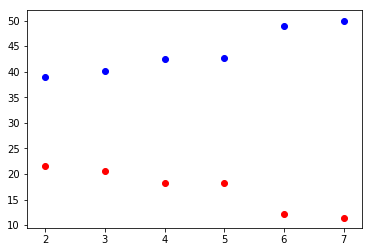

In [6]:
# We've hidden the `train_and_cross_val` function to save space but you can still call the function!
import matplotlib.pyplot as plt
        
two_mse, two_var = train_and_cross_val(["cylinders", "displacement"])
three_mse, three_var = train_and_cross_val(["cylinders", "displacement", "horsepower"])
four_mse, four_var = train_and_cross_val(["cylinders", "displacement", "horsepower", "weight"])
five_mse, five_var = train_and_cross_val(["cylinders", "displacement", "horsepower", "weight", "acceleration"])
six_mse, six_var = train_and_cross_val(["cylinders", "displacement", "horsepower", "weight", "acceleration", "model year"])
seven_mse, seven_var = train_and_cross_val(["cylinders", "displacement", "horsepower", "weight", "acceleration","model year", "origin"])
plt.scatter([2,3,4,5,6,7], [two_mse, three_mse, four_mse, five_mse, six_mse, seven_mse], c='red')
plt.scatter([2,3,4,5,6,7], [two_var, three_var, four_var, five_var, six_var, seven_var], c='blue')
plt.show()

While the higher order multivariate models overfit in relation to the lower order multivariate models, the in-sample error and out-of-sample didn't deviate by much. The best model was around 50% more accurate than the simplest model. On the other hand, the overall variance increased around 25% as we increased the model complexity. This is a really good starting point, but your work is not done! The increased variance with the increased model complexity means that your model will have more unpredictable performance on truly new, unseen data.